<a href="https://colab.research.google.com/github/Farmhouse121/Adventures-in-Financial-Data-Science/blob/main/Book/Section%202.4%20Interest%20Rates/Section%202.4.2.3%20A%20Daily%20Vasicek%20GARCH(1%2C1)%20Model%20with%20Quiet%20Days%20Censored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Installing arch...")
!pip install arch 1>/dev/null
import pandas as pd
import numpy as np ;
import matplotlib.pyplot as pl
from datetime import datetime
zero,one,two,three,five,ten,hundred=0e0,1e0,2e0,3e0,5e0,1e1,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

Installing arch...


In [4]:
# get the bill rate data from Fred
DTB3=pd.read_table('https://fred.stlouisfed.org/data/DTB3.txt',skiprows=11,sep=r'\s+',header=0).rename(columns={"VALUE":"Rate","DATE":"Date"}).set_index("Date")
DTB3.index=pd.DatetimeIndex(DTB3.index).to_period('D')
DTB3['Rate']=DTB3['Rate'].apply(lambda x:float(x) if x!='.' else np.nan)

# join the recessions data (NBER data at Fred) 
USREC=pd.read_table('https://fred.stlouisfed.org/data/USREC.txt',skiprows=65,sep=r'\s+',header=0).rename(columns={"VALUE":"Recession","DATE":"Date"}).set_index("Date")
USREC.index=pd.DatetimeIndex(USREC.index).to_period('D')
DTB3=DTB3.merge(USREC,left_index=True,right_index=True,how='outer')
DTB3['Recession'].ffill(inplace=True)
DTB3['Recession']=DTB3['Recession'].apply(lambda x:True if x else False)
DTB3.dropna(inplace=True)
DTB3['Year']=DTB3.index.year
DTB3.index=pd.DatetimeIndex(DTB3.index.to_timestamp()).to_period('B') # business days
DTB3['Change']=DTB3['Rate']-DTB3['Rate'].shift().ffill() # changes that skip over holidays, why is this so hard?
DTB3.dropna(inplace=True)
display(DTB3)

,Rate,Recession,Year,Change
Date,,,,
1954-01-05,1.28,True,1954,-0.05
1954-01-06,1.28,True,1954,0.00
1954-01-07,1.31,True,1954,0.03
1954-01-08,1.31,True,1954,0.00
1954-01-11,1.33,True,1954,0.02
...,...,...,...,...
2023-03-28,4.64,False,2023,-0.11
2023-03-29,4.64,False,2023,0.00
2023-03-30,4.80,False,2023,0.16


,Rate,Recession,Year,Change
Date,,,,
1954-01-05,1.28,True,1954,-0.05
1954-01-07,1.31,True,1954,0.03
1954-01-11,1.33,True,1954,0.02
1954-01-12,1.30,True,1954,-0.03
1954-01-14,1.28,True,1954,-0.02
...,...,...,...,...
2023-03-27,4.75,False,2023,0.18
2023-03-28,4.64,False,2023,-0.11
2023-03-30,4.80,False,2023,0.16


Optimization terminated successfully    (Exit mode 0)
            Current function value: 43290.08334793482
            Iterations: 19
            Function evaluations: 194
            Gradient evaluations: 19
                                AR-X - GARCH Model Results                                
Dep. Variable:                             Change   R-squared:                       0.018
Mean Model:                                  AR-X   Adj. R-squared:                  0.018
Vol Model:                                  GARCH   Log-Likelihood:               -43290.1
Distribution:      Generalized Error Distribution   AIC:                           86594.2
Method:                        Maximum Likelihood   BIC:                           86647.1
                                                    No. Observations:                14194
Date:                            Wed, Apr 05 2023   Df Residuals:                    14191
Time:                                    16:14:26   Df Model: 

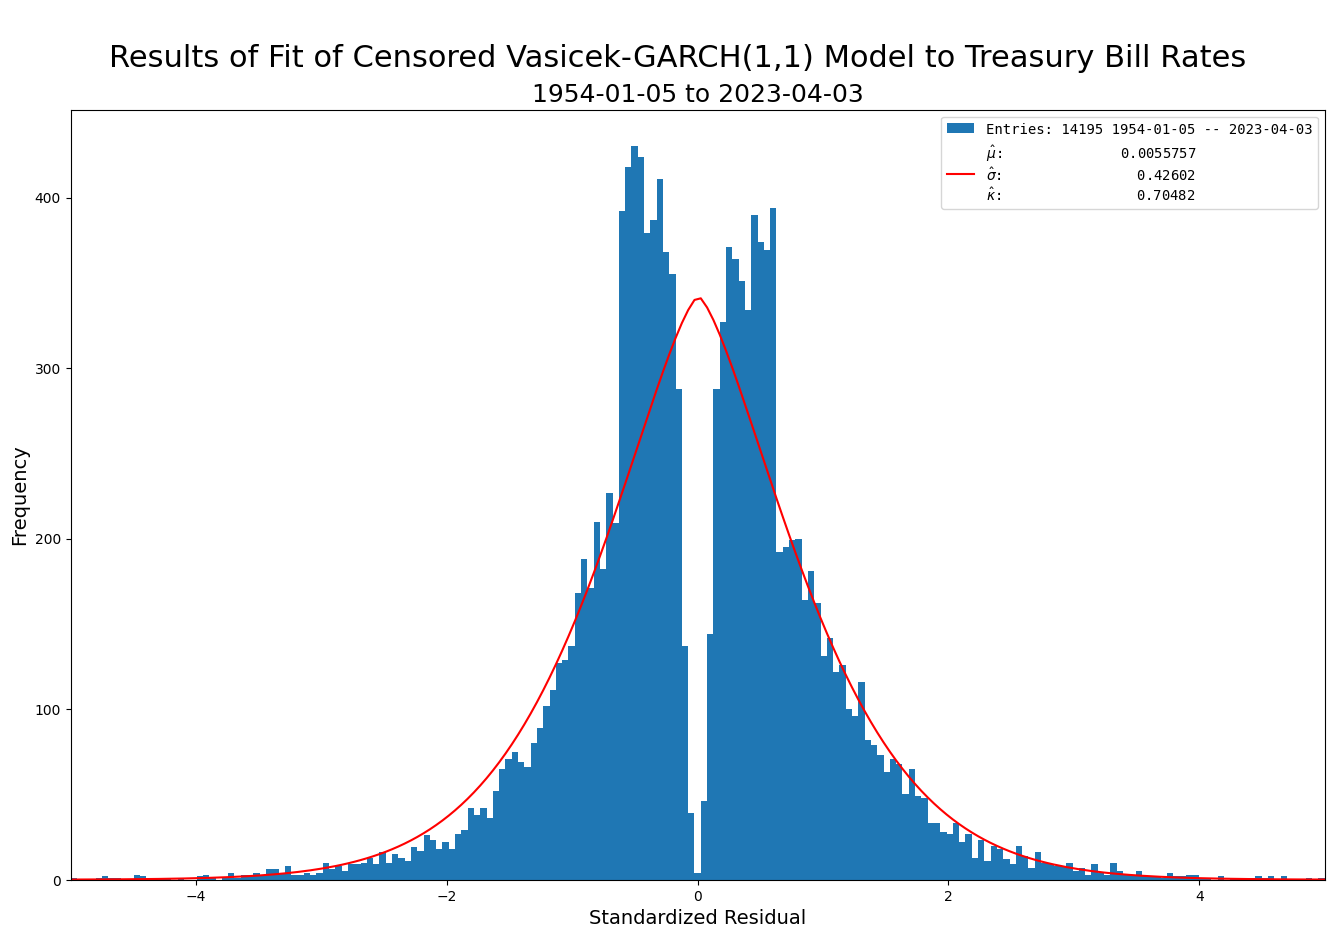

In [5]:
from arch.univariate import ARX, GARCH, GeneralizedError
from scipy.stats import gennorm # gennorm is parameterized in such a manner that kappa=1/beta and sigma=scale/(2^kappa)
censored=DTB3[DTB3["Change"]!=zero].copy()
display(censored)
model = ARX(censored["Change"]*hundred,censored['Rate'].shift().ffill()*hundred,lags=1) # in bp because arch whines about scaling --- bizarre but true
model.volatility = GARCH(1,0,1)
model.distribution = GeneralizedError()
fit=model.fit(update_freq=0)
print(fit.summary())
censored["Volatility"]=fit.conditional_volatility/hundred
censored["Innovations"]=censored["Change"]/censored["Volatility"]

# Figure 2.18
figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
figure.suptitle("\nResults of Fit of Censored Vasicek-GARCH(1,1) Model to Treasury Bill Rates",fontsize=22)
plot.set_title("%s to %s" % (min(DTB3.index),max(DTB3.index)),fontsize=18)
xmin,xmax=-five,five
estimates=gennorm.fit(censored['Innovations'].dropna())
model=gennorm(*estimates)
samples,bins,patches=plot.hist(censored['Innovations'],bins=np.linspace(xmin,xmax,200),label="""Entries: %d %s -- %s""" % (
    censored["Change"].count(),censored.index[0],censored.index[-1],
))
plot.plot(bins,model.pdf(bins)*sum(samples)*(bins[-1]-bins[0])/len(bins),'-r',label="""$\\hat{\\mu}$:           %12.5g
$\\hat{\\sigma}$:           %12.5f
$\\hat{\\kappa}$:           %12.5f""" % (estimates[-2],estimates[-1]/np.power(two,estimates[0]),one/estimates[0]))
plot.set_xlabel("Standardized Residual",fontsize=14)
plot.set_ylabel("Frequency",fontsize=14)
plot.set_xlim(xmin,xmax)
plot.legend(fontsize=18,prop={'family':'monospace'});